# Convolutionnal Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [104]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [139]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="float32")
white = np.array(white, dtype="float32")

clean_dataset = []
white_dataset = []

samples_length = nperseg*2

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

In [140]:
stft_clean_dataset_real = []
stft_clean_dataset_imag = []
stft_white_dataset_real = []
stft_white_dataset_imag = []

for i in clean_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_clean_dataset_real.append(np.real(inp).T)
    stft_clean_dataset_imag.append(np.imag(inp).T)
    
for i in white_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_white_dataset_real.append(np.real(inp).T)
    stft_white_dataset_imag.append(np.imag(inp).T)

max_clean = 1.#np.max(np.abs(np.array(stft_clean_dataset_real)))
max_white = 1.#np.max(np.abs(np.array(stft_white_dataset_real)))

stft_clean_dataset_real = np.array(stft_clean_dataset_real)/max_clean
stft_clean_dataset_imag = np.array(stft_clean_dataset_imag)
stft_white_dataset_real = np.array(stft_white_dataset_real)/max_white
stft_white_dataset_imag = np.array(stft_white_dataset_imag)
print(stft_clean_dataset_real.shape, stft_clean_dataset_imag.shape, stft_white_dataset_real.shape, stft_white_dataset_imag.shape)

(5329, 5, 513) (5329, 5, 513) (5329, 5, 513) (5329, 5, 513)


In [144]:
spectrogram_clean_dataset = []
spectrogram_white_dataset = []

for sample in stft_clean_dataset_real:
    spectrogram_clean_dataset.append(librosa.amplitude_to_db(sample, ref=np.max))
for sample in stft_white_dataset_real:
    spectrogram_white_dataset.append(librosa.amplitude_to_db(sample, ref=np.max))

spectrogram_clean_dataset = np.array(spectrogram_clean_dataset)
spectrogram_white_dataset = np.array(spectrogram_white_dataset)

In [145]:
data_shape = (spectrogram_white_dataset.shape[1:])

In [146]:
data_shape

(5, 513)

In [147]:
print(np.max(np.abs(np.array(spectrogram_clean_dataset))), np.max(np.abs(np.array(spectrogram_white_dataset))))

80.00001 80.00001


In [148]:
def view_output(dataset, gan, p):
    outputs = []
    for i in range(10):
        y = np.reshape(dataset[i, :, :], (-1, dataset.shape[1], dataset.shape[2]))
        t, y1 = istft(np.reshape((gan.g.predict(y)*max_clean).T, data_shape[::-1])+np.imag(dataset[i]).T)
        y2 = np.reshape(y1.T, (dataset.shape[1],))
        outputs.append(y2)
    b = np.concatenate(outputs)
    c, t, bxx = stft(b, fs=samplerate, nperseg=nperseg)
    displaySpectrogram(bxx)
    plt.savefig(str(p)+".png", format='png')

In [127]:
def hear_outputs(dataset, gan, p):
    outputs = []
    for i in range(10):
        y = np.reshape(stft_white_dataset_real[i, :, :], (-1, dataset.shape[1], dataset.shape[2]))
        t, y1 = istft(np.reshape((gan.g.predict(y)*max_clean), data_shape[::-1])+np.imag(dataset[i]).T)
        y2 = np.reshape(y1.T, (dataset.shape[1],))
        outputs.append(y2)
    b = np.concatenate(outputs)
    return Audio(b, rate=samplerate)

# CGAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

A first model is saved in `'save2/gan_without_add'`. It does not have any add layer. It has been train on 3104 steps on 5000 samples of size 2048, visualizable in the folder `save2` gif.

A first model is saved in `'save2/gan_with_add'`. It does have an add layer. It has been train on 2475 steps on 10000 samples of size 1024, visualizable in the folder `save3` gif.

### Discriminator

The discriminator here uses a layer to process the Short-Time Fourier Transform (https://en.wikipedia.org/wiki/Short-time_Fourier_transform) before reducing the problem dimension to one single boolean prediction layer.

Interestingly, adding a Dropout layer on the input seems to prevent the generator to adapt itself to the little flaws of detection (which then only produces noise unrecognized by the discriminator).

In [111]:
def discriminator(input_shape):
    inputs = tf.keras.Input(shape=(input_shape[1], input_shape[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    #x3 = tf.keras.layers.Dense(512, activation="tanh")(x)
    x4 = tf.keras.layers.Dense(256, activation="tanh")(x)
    x41 = tf.keras.layers.Dropout(0.3)(x4)
    x5 = tf.keras.layers.Dense(128, activation="tanh")(x)
    x6 = tf.keras.layers.Dense(1, activation="tanh")(x5)
    x7 = tf.keras.layers.Flatten()(x6)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x7)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer= 'adam', loss='mse', metrics=['accuracy'])
    return model

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [112]:
def generator(sizes):
    inputs = tf.keras.Input(shape=(sizes[1], sizes[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    x1 = tf.keras.layers.Dense(10, activation='tanh')(x)
    x11 = tf.keras.layers.Dropout(0.3)(x1)
    x4 = tf.keras.layers.Dense(sizes[2], activation='tanh')(x11)
    x41 = tf.keras.layers.Dropout(0.3)(x4)
    x5 = tf.keras.layers.Add()([inputs, x41])
    outputs = tf.keras.layers.Dense(sizes[2], activation='linear')(x5)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [113]:
def evaluate_generator(g, inputs, outputs, size=100):
    res = 0
    s = min(size, inputs.shape[0])
    for i in range(s):
        error = (g.predict(np.reshape(inputs[i], (-1, inputs[i].shape[0], inputs[i].shape[1])))-outputs[i])**2
        res += np.sum(error)
    return res/(s)

## Building the GAN

In [114]:
def get_generator_outputs(white, train_size, g, nperseg, clean):
    steps = train_size//20
    rng = np.random.default_rng()
    g_outputs = []
    batch = rng.choice(white, train_size)
    for i in range(train_size):
        if i%steps == 0:
            print("=", end='')
        t = np.reshape(white[i, :, :], (-1, white.shape[1], white.shape[2]))
        m = g.predict(t)
        g_outputs.append(m)
    print()
    g_outputs = np.reshape(np.array(g_outputs), (train_size,  white.shape[1], white.shape[2]))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((np.zeros((train_size,)), np.ones((train_size,))))
    return input_data, output_data

In [115]:
class GAN:
    def __init__(self, size, g, d):
        self.g = g
        self.d = d
        self.size = size
        self.build()
        
    def build(self):
        self.z = self.g.inputs
        self.image = self.g(self.z)
        self.valid = self.d(self.image)
        self.combined_network = tf.keras.Model(self.z, self.valid)
        self.compile()
        
    def block_discriminator(self):
        self.d.trainable = False
        self.g.trainable = True
        self.build()
        
    def block_generator(self):
        self.g.trainable = False
        self.d.trainable = True
        self.build()
        
    def compile(self):
        self.combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [116]:
g = generator(spectrogram_white_dataset.shape)
d = discriminator(spectrogram_white_dataset.shape)
gan = GAN(spectrogram_white_dataset.shape, g, d)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 128, 5)       0           input_17[0][0]                   
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 128, 10)      60          dropout_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 128, 10)      0           dense_56[0][0]                   
________________________________________________________________________________________

In [118]:
def train_on_batch(d, i, o, validation_split=0, batch_size=16, verbose=True):
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [128]:
discriminator_train_size = 300#(spectrogram_white_dataset.shape[0])
generator_train_size = 300#spectrogram_white_dataset.shape[0]

### Pretraining the discriminator

d_accuracy = 0
while d_accuracy < 0.5:
    d_accuracy = train_on_batch(gan.d, np.concatenate((stft_white_dataset_real[:train_size], stft_clean_dataset_real[:train_size])), np.concatenate((np.zeros(train_size), np.ones(train_size))), verbose=True)

In [129]:
p = 1
q = 1

Step 0
Training the discriminator
38/38 [==============================] - 0s 2ms/step - loss: 2.9728e-05 - accuracy: 1.0000
Training the generator
75/75 [==============================] - 0s 1ms/step - loss: 0.9902 - accuracy: 0.0000e+00
2.943499373527973e+24


ValueError: too many values to unpack (expected 2)

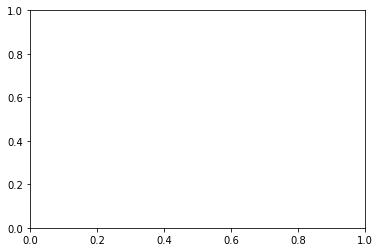

In [138]:
disc_acc = []
gen_loss = [0]
gan_acc = []
for e in range(10):
    g_accuracy = 0
    d_accuracy = 0
    print("Step", e)
    if d_accuracy < 1:
        i, o = get_generator_outputs(spectrogram_white_dataset, discriminator_train_size, gan.g, nperseg, spectrogram_clean_dataset)
    gan.block_generator()
    print("Training the discriminator")
    s = 0
    err = evaluate_generator(gan.g, spectrogram_white_dataset, spectrogram_clean_dataset, 100)
    while d_accuracy < 0.9:
        d_accuracy = train_on_batch(gan.d, i, o, verbose=True)
        disc_acc.append(d_accuracy)
        gan_acc.append(0)
        s+=1
        gen_loss.append(err)
    gan.block_discriminator()
    print("Training the generator")
    s = 0
    while g_accuracy < 0.95:
        g_accuracy = train_on_batch(gan.combined_network, spectrogram_white_dataset[:generator_train_size], np.ones(generator_train_size), batch_size=4, verbose=True)
        gan_acc.append(g_accuracy)
        disc_acc.append(0)
        err = evaluate_generator(gan.g, spectrogram_white_dataset, spectrogram_clean_dataset, 100)
        print(err)
        gen_loss.append(err)
        view_mel(spectrogram_white_dataset, gan, p)
        s+=1
        p+=1
    #print(evaluate_generator(gan.g, white_dataset, clean_dataset))
plt.plot(disc_acc)
plt.plot(gan_acc)
plt.show()
plt.plot(gen_loss[1:])
plt.show()

gan.combined_network.save('save3/gan_with_add')

In [84]:
hear_outputs(spectrogram_clean_dataset, gan, p)